# A plot says more than 1000 tables: Visualizing missing data with `missingno`

Real-world data sets are very rarely free of missing values. Their causes are manifold: A participant could just have overlooked a survey item but it could also have been a controversial question where answers are refused by some. They could have been introduced completely at random, for example by logging errors, or systematically, for example because a condition was not met or a sensor was not recording. 

Independent of their cause, there are two representations of missing values in Numpy/Pandas: `None` and `NaN`. `None` is the sentinel value implemented in arrays with dtype `object`, while `NaN` is a special floating-point value. Pandas was designed to handle both almost interchangeably. 

Even if the machine learning application of your choice may digest data containing missing values, this simply means that they are ignored. Thus, no matter what you are doing, the decision whether to drop/ignore or to impute the missing values must be made. There are no fixed rules which method is better or even correct, both have advantages and disadvantages. It all comes down to the peculiarities of the data set at hand and to one's understanding of this data set including its data generating process. But consensus is that the extend of missingness, its systematic, and interpretability are the key factors to a sensible decision in this case. Otherwise, you will either throw away a lot of information or introduce bias. 

There is an extensive discussion of the various techniques for dealing with missing values in the literature, which is out of the scope of this blog post. In this post, I rather want show how to approach a yet unseen data set and how to inspect the missing values with the package [`missingno`](https://github.com/ResidentMario/missingno)<span style="font-size:12px;"><sup>1</sup></span>. A plot says more than 1000 tables, that's why the package is so helpful here. It provides four ways to visually summarize the missing values, which give a great overview on the extend, patterns, and inter-relationship of missing data. Before this, I will begin with some preprocessing steps that bring the data in the right shape and make the analysis of missing values easier later.

The analyzed dataset contains listings of homestays in Boston, MA and Seattle, WA on [airbnb.com](https://www.airbnb.com). More details and a download link of the data set can be found [here](https://www.kaggle.com/airbnb/boston) and [here](https://www.kaggle.com/airbnb/seattle/data). 

Okay, let's go!

# The missingno package

First, let's load the required packages.

In [1]:
# load packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os import listdir
from tabulate import tabulate

# some output options
%matplotlib inline

pd.options.display.max_rows = 30

Before this analysis, I did some preprocessing on the variable types and already merged the two data set into a single new data frame, `df`.

Before I check for missing data, I remove every feature that is certainly not related to the research question at hand and is of no predictive use anymore. For example, if you do not plan to join the data set with other data sets, you can safely remove identifiers such as `id`. You may find more variables that are not informative, but this is my selection of variables that can be definitely dropped for this blog post. In the end, it completely depends on your goal.

In [25]:
df = df.drop(['id', 'listing_url', 'scrape_id', 'name', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url'], axis = 1)

Okay, let's go check out the four plots of `missingno`.

In [26]:
# import missingno package
import missingno as msno

## 1. bar()

`bar()` visualizes the nullity by column.

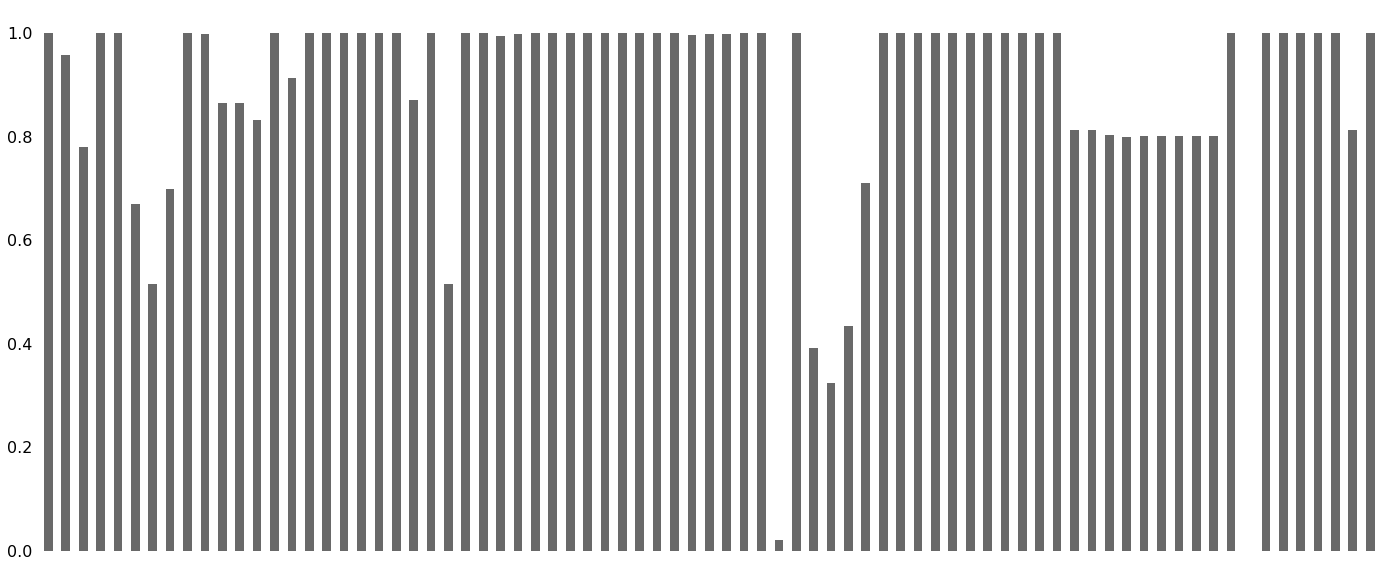

In [27]:
msno.bar(df)

That certainly looks confusing. Of course, a plot including all features makes sense to see what features are completely missing or completely present at first glance. But in all other cases, we first need to thin the data set before we proceed. 

First, drop columns with no valid values:

In [28]:
df = df.dropna(how = 'all', axis = 1)

Drop any duplicate rows (just in case...):

In [29]:
df = df.drop_duplicates()

Next, remove constant features:

In [30]:
from sklearn.feature_selection import VarianceThreshold

nzv = VarianceThreshold(threshold = 0.01) # only columns with more than 1% variance are retained

# since the function digests only numericals and no NaNs, we need to select them
nums = (df.select_dtypes(include=['number'])).dropna(how = 'any', axis = 0)

# apply the selector
nzv.fit(nums)

nums.columns[~nzv.get_support()] # excluded columns

Index([], dtype='object')

No near zero variance columns are in the data set and, thus, no column will be removed in this step. Since we still have 76 columns, analyzing the missing data might be more insightful if we just look at the columns that in fact exhibit missing cases at some points (and it's faster).

In [31]:
# define date frame that contains only columns with at least one missing value
df_miss = df.loc[:, df.isna().any(axis = 0)]

Tabulate proportion of NA per column. The output is again truncated to only include features with more than 2.5% missing values.

In [32]:
truncate = df_miss.isna().mean() > .025
pd.DataFrame({'sum': df_miss.loc[:, truncate].isna().sum(), 'mean': df_miss.loc[:, truncate].isna().mean()}).round(3).sort_values(by = 'mean', ascending = False)

sum   mean
square_feet                   7250  0.979
monthly_price                 4998  0.675
weekly_price                  4502  0.608
security_deposit              4195  0.567
neighbourhood_group_cleansed  3585  0.484
notes                         3581  0.484
neighborhood_overview         2447  0.331
transit                       2224  0.300
cleaning_fee                  2137  0.289
space                         1626  0.220
review_scores_checkin         1478  0.200
review_scores_location        1477  0.200
review_scores_value           1477  0.200
review_scores_accuracy        1481  0.200
review_scores_cleanliness     1471  0.199
review_scores_communication   1469  0.198
review_scores_rating          1460  0.197
reviews_per_month             1383  0.187
last_review                   1383  0.187
first_review                  1383  0.187
host_acceptance_rate          1244  0.168
host_response_rate             994  0.134
host_response_time             994  0.134
neighbourhood                  959  0.130
host_neighbourhood             639  0.086
summary                        320  0.043

`square_feet` seems to be a rotten apple here. Does it hold the same information as `space`?

In [33]:
print(df[['square_feet', 'space']].dtypes)

square_feet    float64
space           object
dtype: object


Nope, space is text!

In [34]:
df['space'].head()

0    The house has an open and cozy feel at the sam...
1    Small but cozy and quite room with a full size...
2    Come stay with a friendly, middle-aged guy in ...
3    Most places you find in Boston are small howev...
4    Clean, attractive, private room, one block fro...
Name: space, dtype: object

Since `square_feet` is missing in 97.9 % of the cases, it adds no predictive value. Removing a feature that has almost no valid values is always rather safe because the potential for introducing bias is low and not much information is discarded.

In [35]:
df, df_miss = map(lambda x: x.drop('square_feet', axis = 1), [df, df_miss])

Plot again:

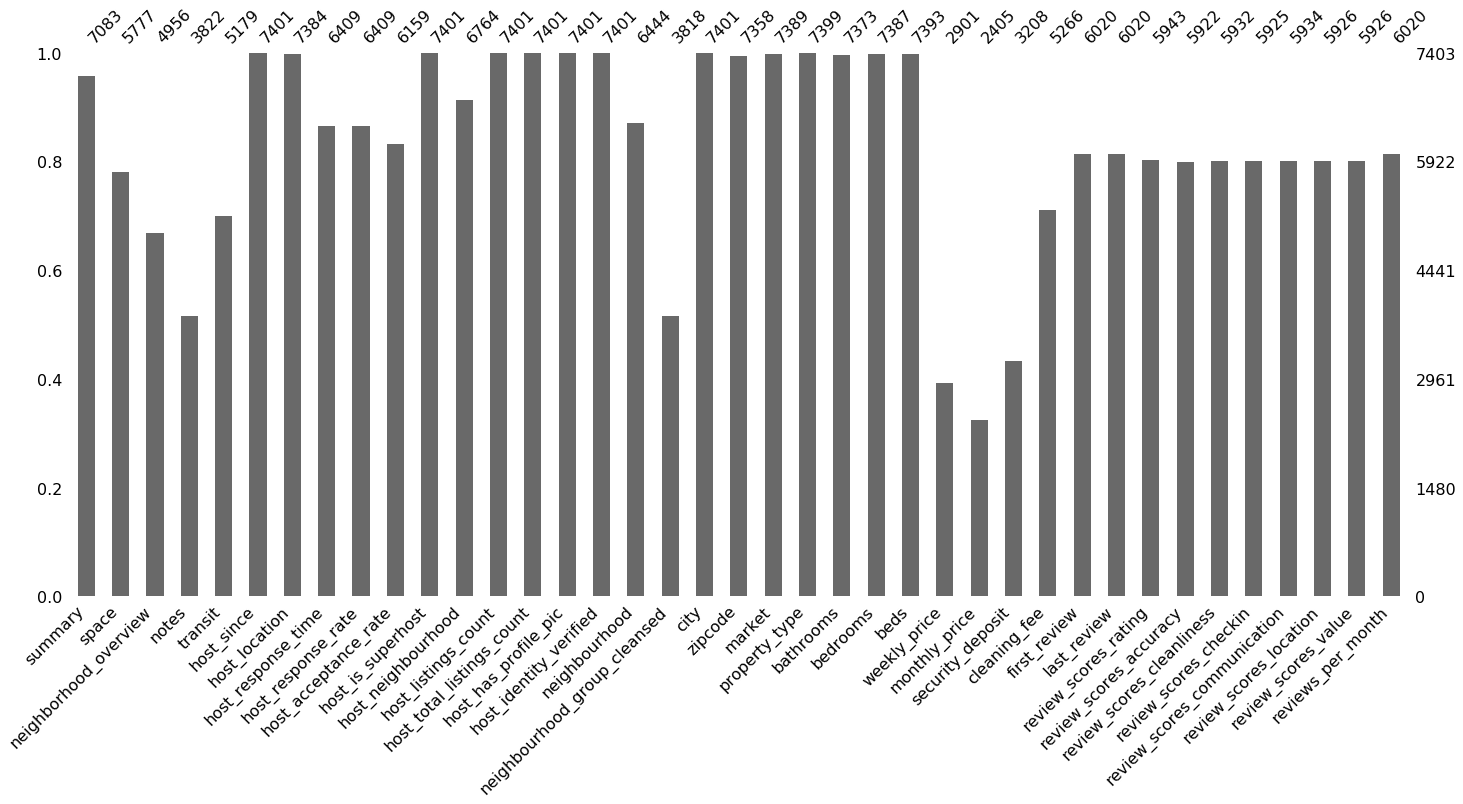

In [36]:
msno.bar(df_miss)

Way better!

## 2. matrix()

`matrix()` provides a nullity matrix to examine missing data by row. It is ideal to visually check whether the missing values follow any pattern. The spark line on the far right marks the most and least complete case.

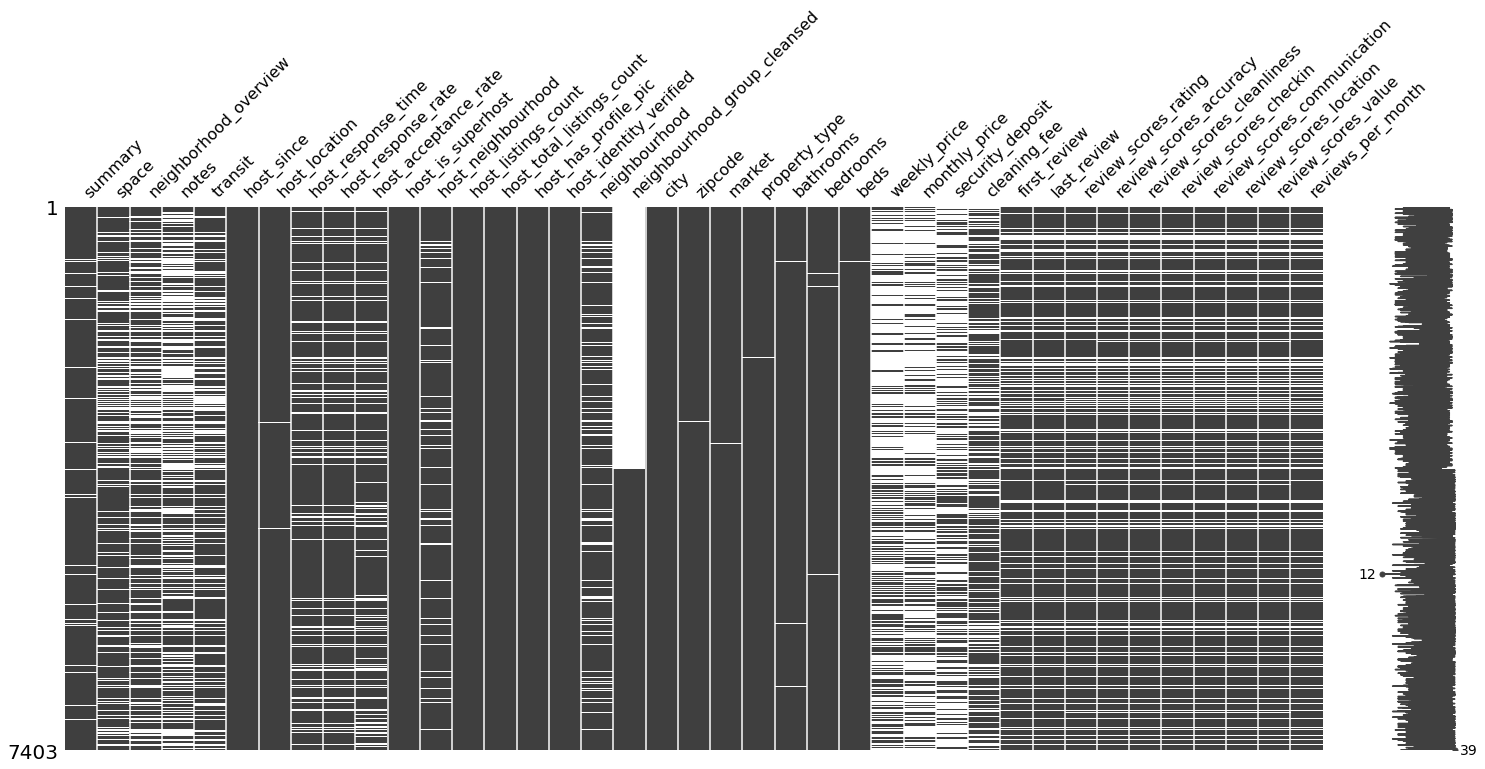

In [37]:
msno.matrix(df_miss)

`sort = 'descending'` sorts the cases by their completeness.

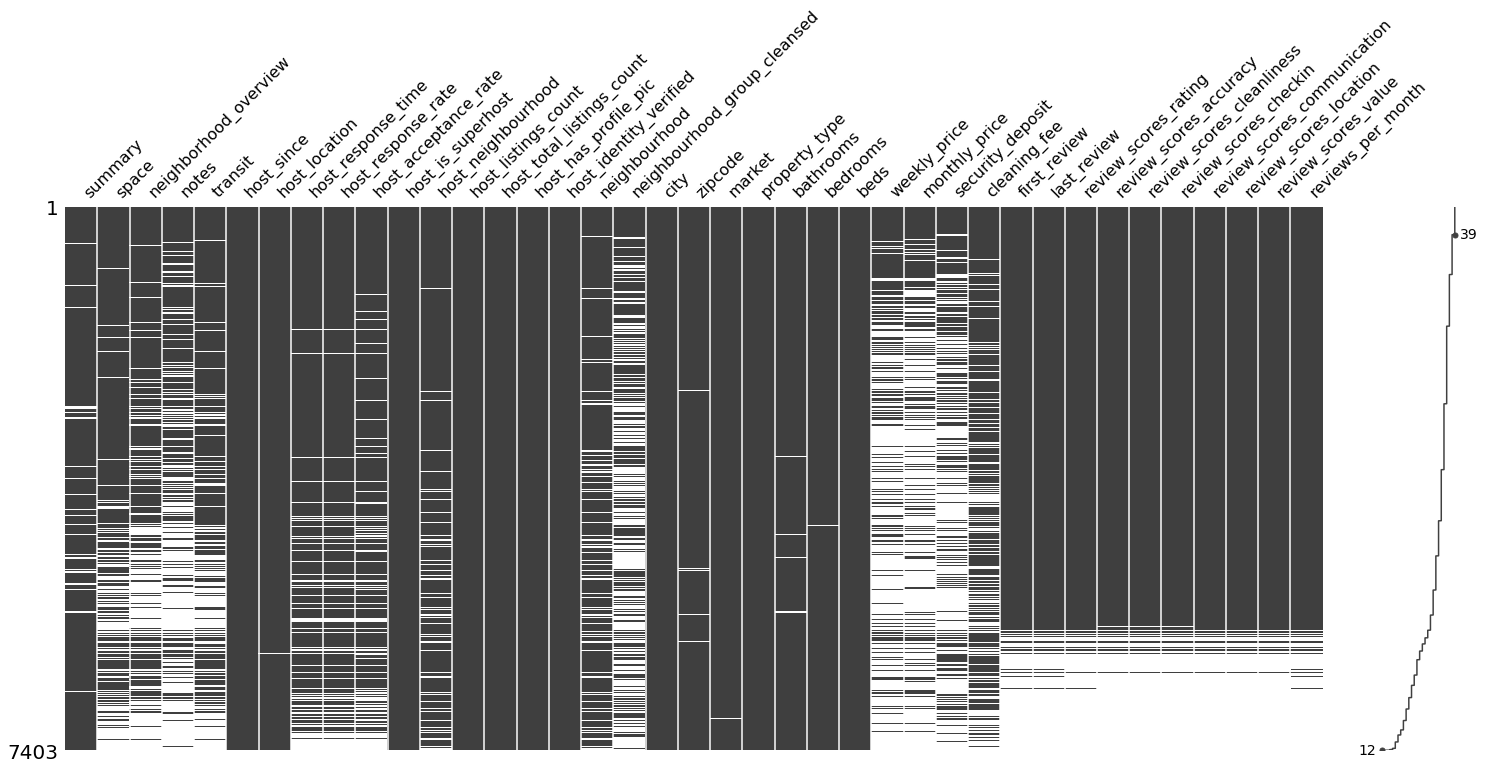

In [38]:
msno.matrix(df_miss, sort = 'descending')

## 3. heatmap()

The `heatmap()` function visualizes how strongly the presence or absence of one variable does affect the presence of another. The visualized nullity correlation ranges from $-1$ (if one variable is present the other is certainly not present; marked in red) to $0$ (presence of one variable has no effect on the presence of the other) to $1$ (if one variable is present the other is certainly also present; marked in blue). Only the bottom half is presented because correlations are symmetric relations, i.e. the correlation between *A* and *B* is the same as between *B* and *A*. Variables with no missing values or no present values are removed from this visualization. Why? Because constant variables show no variance and, therefore, no matter what value another variable exhibits, there is also a present or always a missing value in the variable of question. There is also no diagonal because the correlation of a variable with itself does not make sense in this context.

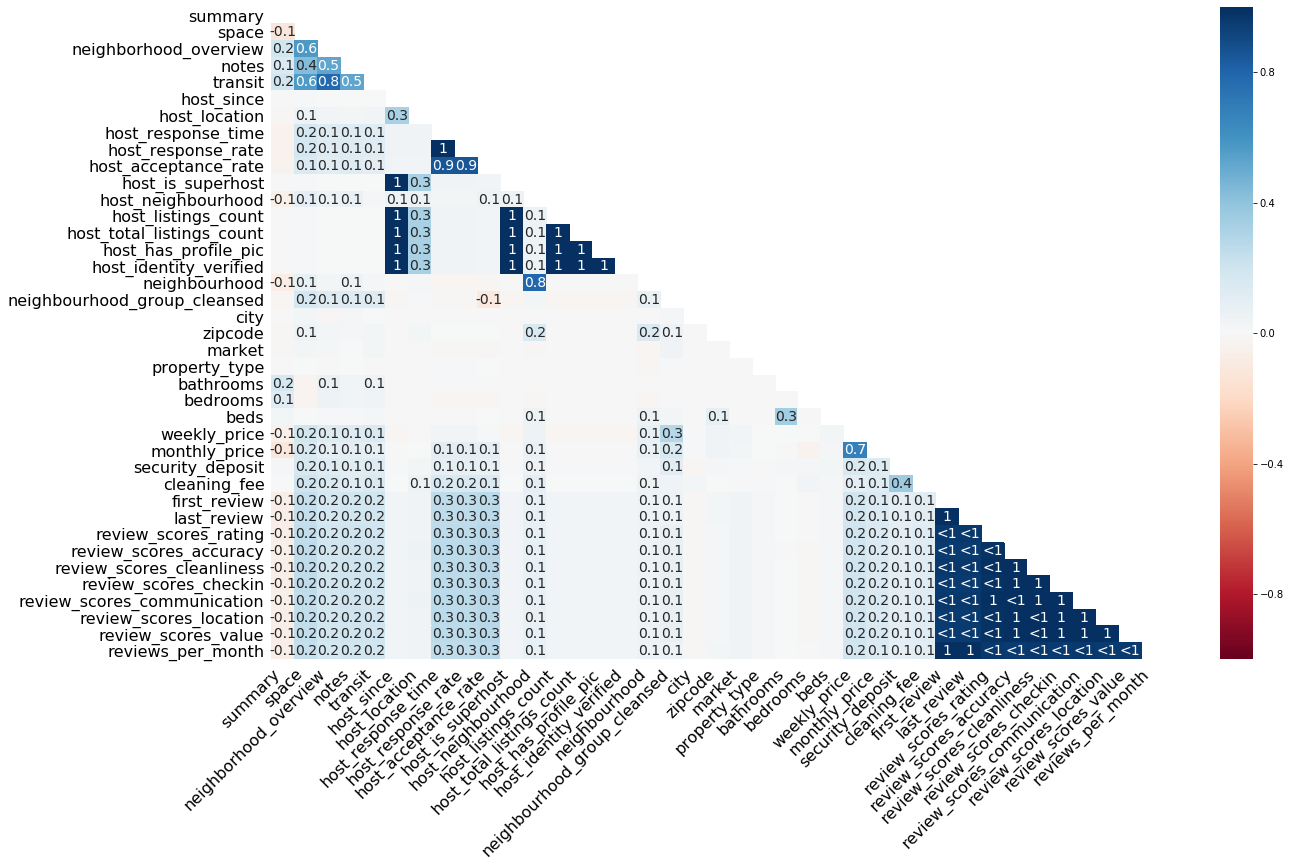

In [39]:
msno.heatmap(df)

The default color scheme is `RdBu`, but you can pick another diverging color scheme by setting the *cmap* parameter (more info on the available color schemes can be found [here](https://matplotlib.org/users/colormaps.html)). 

How to read this plot? Let's pick some numbers. The first $1$ shows up at the correlation between `host_response_time` and `host_response_rate`. Whenever an observation of `host_response_time` is present in a case, an observation of `host_response_rate` is also present (and vice versa). Values close to $1$ or $-1$ are marked by $<1$/$>-1$. These relationships deserve special attention because, for example, at $<1$, an observation is almost always present in both variables, if it is present in any of the two variables, but in a few cases. For example, if there is an observation present in `first_review`, we would expect to see a corresponding observation in `last_review` as well, because this is almost everytime the case. If there is none, there might be a systematic mechanism at work, e. g., a certain condition is fulfilled which prevents data logging.

The function does not print correlations $-.05 < r < .05$, which is the case for the majority of correlations in the plot above. That means there is no linear relationship in the missingness between two variables. We can see that, for example, `cleaning_fee` exhibits a low to zero correlation to other variables. It seems that `cleaning_fee` is also missing if various other details on the accomodation are missing, but this is not necessarily true.

## 4. dendrogram()

Compared to the heatmap, the dendrogram zooms out a bit and helps to reveal clusters of missing datas. That is, not only pairwise relationships but also relationships between groups of variables. The function relies on a [hierarchical clustering algorithm](http://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) to cluster the features based on their missingness measured by binary distance (although other cluster methods can be set as well). The closer features are in this graph (i.e. the earlier their lines meet), the stronger is the link between their missingness. 

Again, it makes sense to exclude variables that have no/only missing values. If the distance of a feature to these features is of interest, they may be included. 

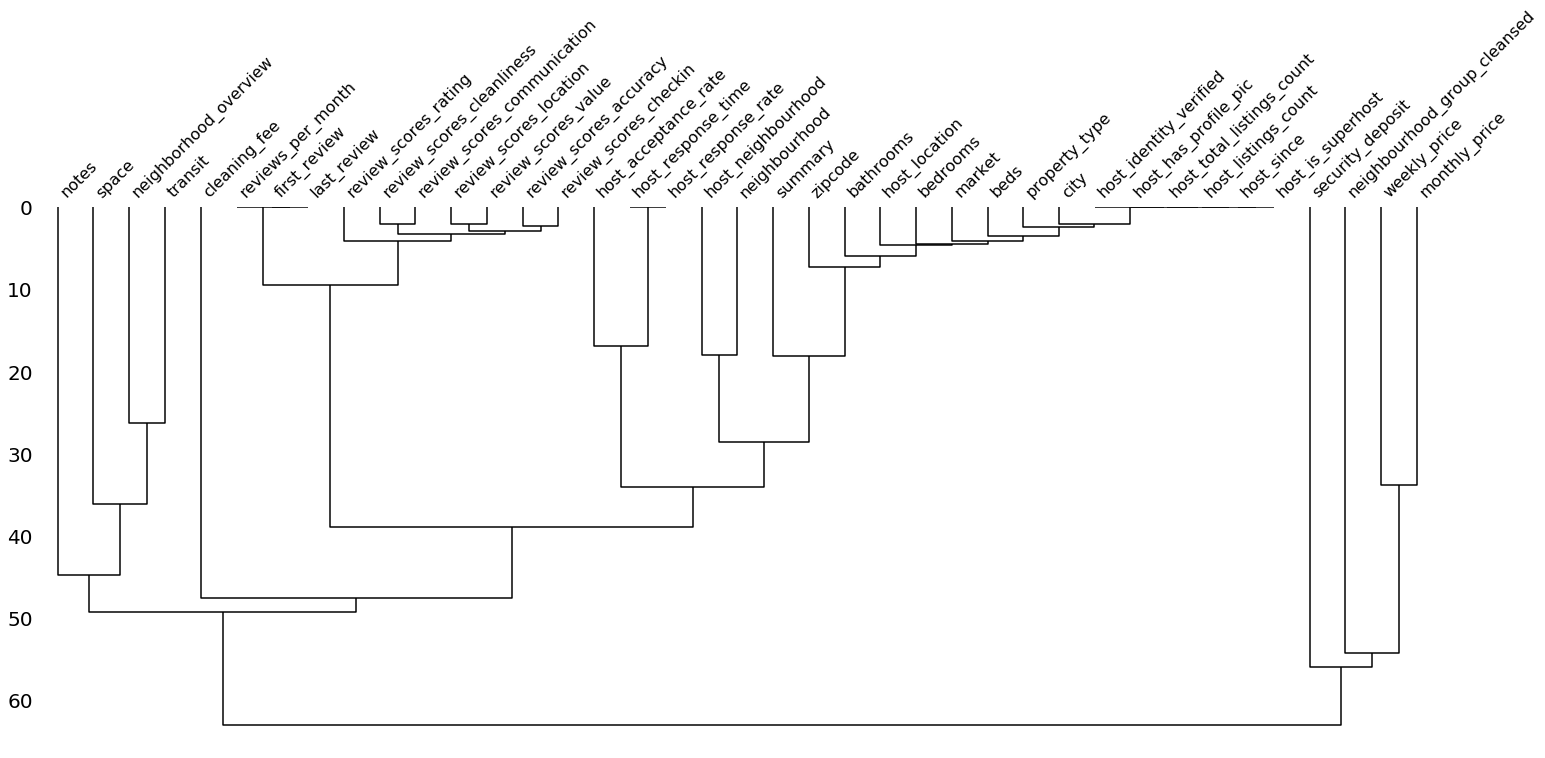

In [40]:
msno.dendrogram(df_miss)

As we can see, the variables that had a correlation of 1 in the plot above already meet at a distance of 0. We can see here that features regarding the review are strongly linked in their missingness â€“ most of the time either all or none of these features are present. The same is true for some but not all host related feautures. If we examine cleaning_fee again, we see that it exhibits a large distance and, therefore, is weakly linked in it's missingness just as we saw in the heatmap. 

We now had a look at the missing values of the data set with the `missingno` package. I hope you enjoyed this intro and are now eager to make some plots for your own data set of choice. 

Obtaining an understanding of the missingness in a data set is only one of many steps to be done before a valid model can be trained. I will go deeper into these preprocessing steps in future blog posts. Stay tuned!

<br>
<br>

Github repo for the package: [https://github.com/ResidentMario/missingno](https://github.com/ResidentMario/missingno)

<span style="font-size:12px;"><sup>1</sup></span> Bilogur, A. (2018). Missingno: a missing data visualization suite. *Journal of Open Source Software*, *3*(22), 547. [https://doi.org/10.21105/joss.00547](https://doi.org/10.21105/joss.00547) 